In [68]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

## Data Import
The open source car dataset from Standford is used in this notebook (source: https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

In [2]:
import scipy.io as sio
matfile = sio.loadmat(r"data\cars_annos.mat")

In [3]:
# get the keys of this dictionary
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [4]:
matfile['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [5]:
data = [[row.flat[0] for row in line] for line in matfile['annotations'][0]]

columns = ["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "test"]

df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,car_ims/000001.jpg,112,7,853,717,1,0
1,car_ims/000002.jpg,48,24,441,202,1,0
2,car_ims/000003.jpg,7,4,277,180,1,0
3,car_ims/000004.jpg,33,50,197,150,1,0
4,car_ims/000005.jpg,5,8,83,58,1,0


In [7]:
# drop the bounding box information, because we are only applying normal image classification
df = df.drop(columns=["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"])

In [8]:
df.head()

,filename,class,test
0,car_ims/000001.jpg,1,0
1,car_ims/000002.jpg,1,0
2,car_ims/000003.jpg,1,0
3,car_ims/000004.jpg,1,0
4,car_ims/000005.jpg,1,0


In [9]:
# remove the folder car_ims from the filenames to only have the filename
df["filename"] = df["filename"].apply(lambda x: x.replace("car_ims/", ""))
df.head()

,filename,class,test
0,000001.jpg,1,0
1,000002.jpg,1,0
2,000003.jpg,1,0
3,000004.jpg,1,0
4,000005.jpg,1,0


In [10]:
# get some statistics
df.describe()

,class,test
count,16185.000000,16185.000000
mean,98.977448,0.496818
std,56.502610,0.500005
min,1.000000,0.000000
25%,50.000000,0.000000
50%,99.000000,0.000000
75%,148.000000,1.000000
max,196.000000,1.000000


In [11]:
# check unique values and get number of classes
for column in df.columns:
    print(f"Column {column} contains {df[column].unique().shape[0]} unique values. { 100 * df[column].unique().shape[0] / df[column].shape[0]}% of total data. \n")

Column filename contains 16185 unique values. 100.0% of total data. 

Column class contains 196 unique values. 1.2109978375038617% of total data. 

Column test contains 2 unique values. 0.01235712079085573% of total data. 



There are in total 196 different classes available. Let's now check how many of the images are used for testing.

In [12]:
num_images = df.shape[0]
num_test = np.sum(df["test"] == 1)
print(f"There are {num_images} images in this dataset.")
print(f"{num_test} of these images are in the test set ({100 * num_test / num_images}% of total data).")

There are 16185 images in this dataset.
8041 of these images are in the test set (49.68180413963547% of total data).


In [13]:
# get the class names
class_names = [[row.flat[0] for row in line] for line in matfile['class_names'][0]]

In [14]:
class_names = [class_names[idx][0] for idx in range(len(class_names))]

In [15]:
class_names

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

There are a lot of different classes but we only have few images. Let's reduce the training effort and the amount of classes to train on by only predicting which manufacturer produced the car and not also which exact model we have here!

In [16]:
list_long_manufacturer = ["Aston Martin", "Land Rover"]
new_class_names = list(set( [full_name.split(" ")[0] if not any([manu in full_name for manu in list_long_manufacturer])
                                                     else " ".join(full_name.split(" ")[:2])
                                                     for full_name in class_names] ))

In [17]:
new_class_names

['Ford',
 'Mazda',
 'Eagle',
 'Jeep',
 'FIAT',
 'Plymouth',
 'GMC',
 'Toyota',
 'Geo',
 'Chevrolet',
 'Chrysler',
 'Cadillac',
 'Lamborghini',
 'Volvo',
 'Dodge',
 'Nissan',
 'BMW',
 'Rolls-Royce',
 'Honda',
 'Ferrari',
 'Volkswagen',
 'Tesla',
 'Scion',
 'Audi',
 'Buick',
 'Bentley',
 'Suzuki',
 'Mercedes-Benz',
 'MINI',
 'Ram',
 'Fisker',
 'Porsche',
 'AM',
 'Daewoo',
 'Spyker',
 'Land Rover',
 'HUMMER',
 'Isuzu',
 'McLaren',
 'smart',
 'Hyundai',
 'Mitsubishi',
 'Maybach',
 'Jaguar',
 'Aston Martin',
 'Acura',
 'Infiniti',
 'Bugatti',
 'Lincoln']

In [18]:
# get new number of classes
print(f"New number of classes: {len(new_class_names)}")

New number of classes: 49


Nice! Now we only have 49 classes left. But before we continue, we first have to map the old class integers to the new ones in order to not flip everything! Let's do this first. <br> 
Let's use the index of the new classes list and map each old class with manufacturer and model name to the new index where we only have the manufacturer left. For this, dictionaries are a nice choice!

In [19]:
dict_old_class_to_new_class = {}
new_indices = np.arange(len(new_class_names))
for old_class in class_names:
    new_index = new_indices[[new_class in old_class for new_class in new_class_names]]
    dict_old_class_to_new_class[old_class] = new_index[0]

In [20]:
dict_old_class_to_new_class

{'AM General Hummer SUV 2000': 32,
 'Acura RL Sedan 2012': 45,
 'Acura TL Sedan 2012': 45,
 'Acura TL Type-S 2008': 45,
 'Acura TSX Sedan 2012': 45,
 'Acura Integra Type R 2001': 45,
 'Acura ZDX Hatchback 2012': 45,
 'Aston Martin V8 Vantage Convertible 2012': 44,
 'Aston Martin V8 Vantage Coupe 2012': 44,
 'Aston Martin Virage Convertible 2012': 44,
 'Aston Martin Virage Coupe 2012': 44,
 'Audi RS 4 Convertible 2008': 23,
 'Audi A5 Coupe 2012': 23,
 'Audi TTS Coupe 2012': 23,
 'Audi R8 Coupe 2012': 23,
 'Audi V8 Sedan 1994': 23,
 'Audi 100 Sedan 1994': 23,
 'Audi 100 Wagon 1994': 23,
 'Audi TT Hatchback 2011': 23,
 'Audi S6 Sedan 2011': 23,
 'Audi S5 Convertible 2012': 23,
 'Audi S5 Coupe 2012': 23,
 'Audi S4 Sedan 2012': 23,
 'Audi S4 Sedan 2007': 23,
 'Audi TT RS Coupe 2012': 23,
 'BMW ActiveHybrid 5 Sedan 2012': 16,
 'BMW 1 Series Convertible 2012': 16,
 'BMW 1 Series Coupe 2012': 16,
 'BMW 3 Series Sedan 2012': 16,
 'BMW 3 Series Wagon 2012': 16,
 'BMW 6 Series Convertible 2007': 

In [21]:
# lets now adapt the dataframe to match the new classes
df["new_class"] = df["class"].apply(lambda x: dict_old_class_to_new_class[class_names[x-1]])

In [23]:
df.head()

,filename,class,test,new_class
0,000001.jpg,1,0,32
1,000002.jpg,1,0,32
2,000003.jpg,1,0,32
3,000004.jpg,1,0,32
4,000005.jpg,1,0,32


In [24]:
df["class"].value_counts()

119    136
79      97
161     96
167     95
56      93
      ... 
175     61
64      59
158     58
99      55
136     48
Name: class, Length: 196, dtype: int64

## EDA

Let's first check the shape of the images. For this, let's load some images into numpy arrays and check the shapes. For this, I only want to check the shapes of the first images in order to check whether they are of equal size or not. If not, then different images sizes are to be tested for the final model and the best performing shall be used in the end.

In [26]:
from PIL import Image

def files_to_numpy(df, folder):
    list_of_files = df["filename"][:20].to_list()
    
    # read data into numpy array
    for img_file in list_of_files:
        image = np.array(Image.open(os.path.join(folder, img_file) ))
        print(image.shape)

In [27]:
files_to_numpy(df, r"data\car_ims")

(768, 1024, 3)
(219, 460, 3)
(233, 310, 3)
(188, 250, 3)
(64, 85, 3)
(111, 250, 3)
(176, 464, 3)
(85, 113, 3)
(276, 300, 3)
(111, 148, 3)
(72, 96, 3)
(100, 160, 3)
(179, 300, 3)
(120, 160, 3)
(71, 94, 3)
(93, 124, 3)
(91, 160, 3)
(525, 700, 3)
(272, 450, 3)
(439, 700, 3)


Okay. Seems like there are a lot of different images sizes available. Let's later check different images sizes and train models on them in order to find the best suited. In addition, let's convert the images into grayscale images later, because this should be sufficient for a cars classifier. <br> <br>
Let's now take a look into some images.

In [28]:
def show_image(df, folder, index, classes=new_class_names):
    filename = os.path.join(folder, df["filename"][index])
    class_name = classes[df["new_class"][index]]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.imshow(image)

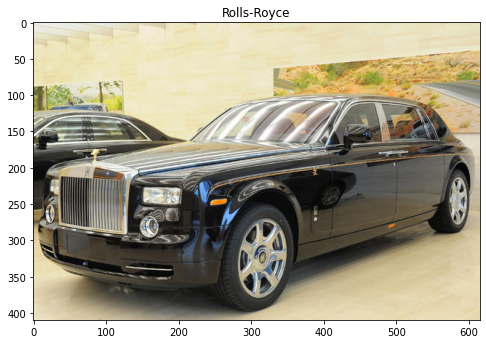

In [29]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

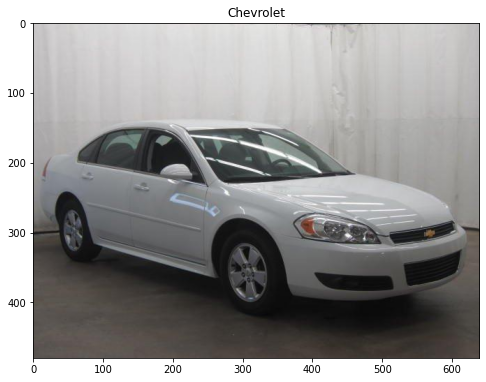

In [30]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

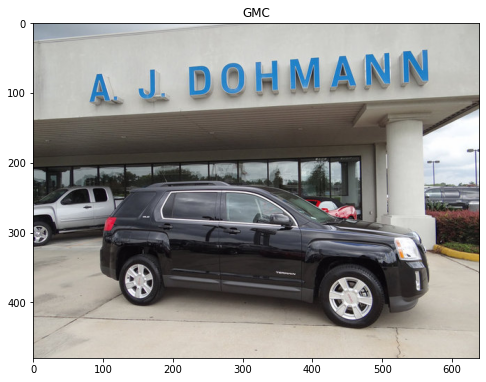

In [31]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

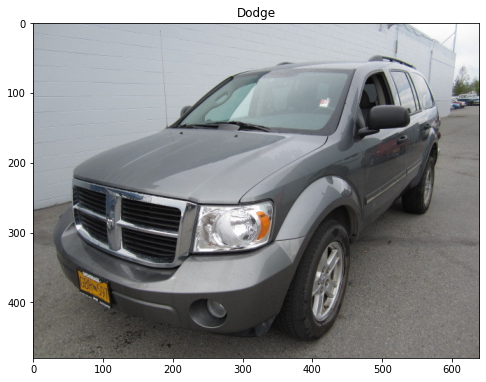

In [32]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

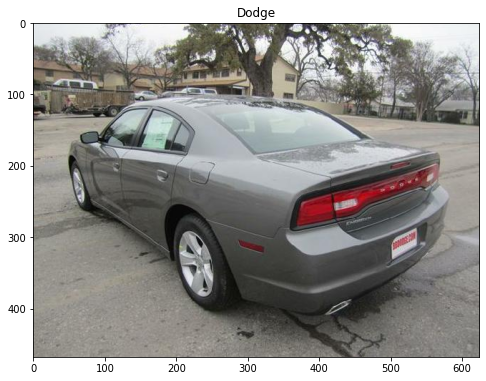

In [33]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

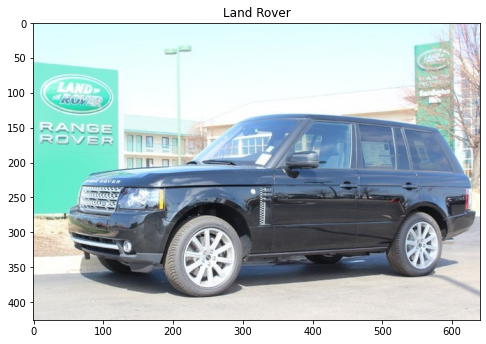

In [34]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

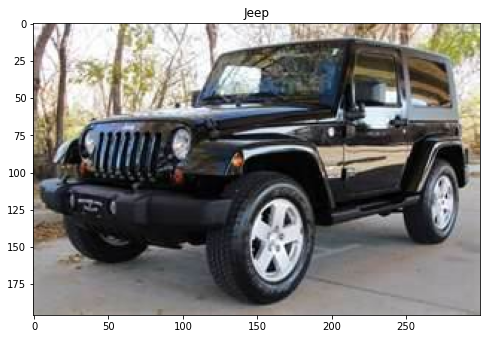

In [35]:
index = np.random.randint(0, num_images)
show_image(df, r"data\car_ims", index)

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

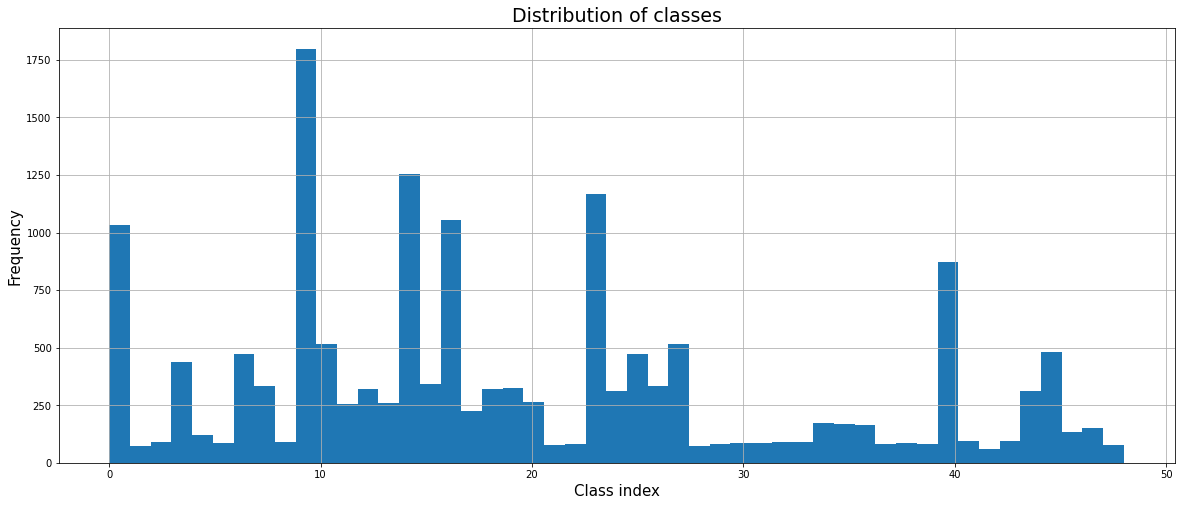

In [36]:
plt.figure(figsize=(20, 8))
df["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set. For this dataset, almost the half of all images are in the test set. I think this is done in order to ensure that there are enough images of all classes in the test set. 

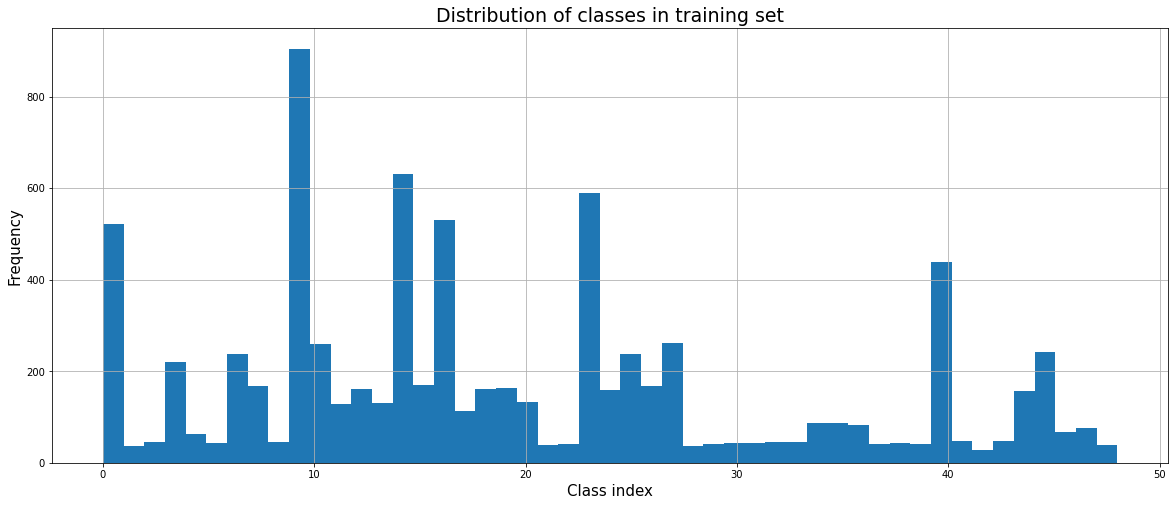

In [39]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 0]["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

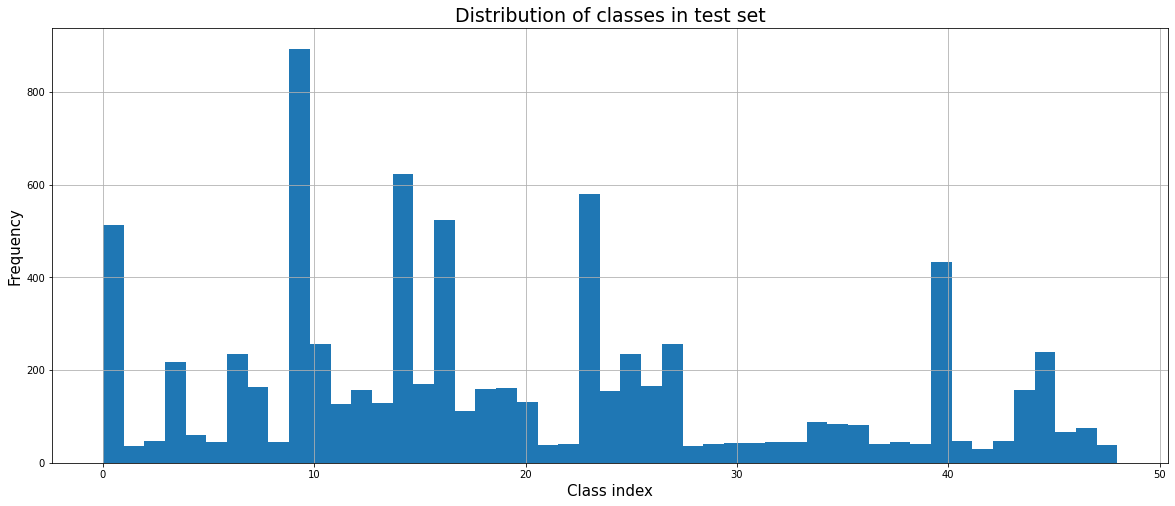

In [40]:
# check distribution of training set
plt.figure(figsize=(20, 8))
df.loc[df["test"] == 1]["new_class"].hist(bins=len(new_class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

As one can see, the distributions are almost the same! This is perfect, because the test set therefore represents the real distribution and we can better test the performance of the final model! <br> <br>
Let's now create a training and a validation set and let's check the distributions there. But before splitting, we should one-hot encode the labels!

In [42]:
# start with one-hot encoding the column "class"
df_encoded = pd.get_dummies(df, columns=["new_class"])
df_encoded.columns = ["filename", "class", "test", *new_class_names]
df_encoded.head()

,filename,class,test,Ford,Mazda,Eagle,Jeep,FIAT,Plymouth,GMC,...,smart,Hyundai,Mitsubishi,Maybach,Jaguar,Aston Martin,Acura,Infiniti,Bugatti,Lincoln
0,000001.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000002.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000003.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000004.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000005.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

df_training = df_encoded.loc[df["test"] == 0]
df_test = df_encoded.loc[df["test"] == 1]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df_training.drop(columns=new_class_names), df_training[new_class_names]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_training.iloc[train_index]
    df_val = df_training.iloc[test_index]

TRAIN: [2434  782 3946 ... 3007 6385  968] TEST: [2293 7901 5076 ...  302 3826 5358]


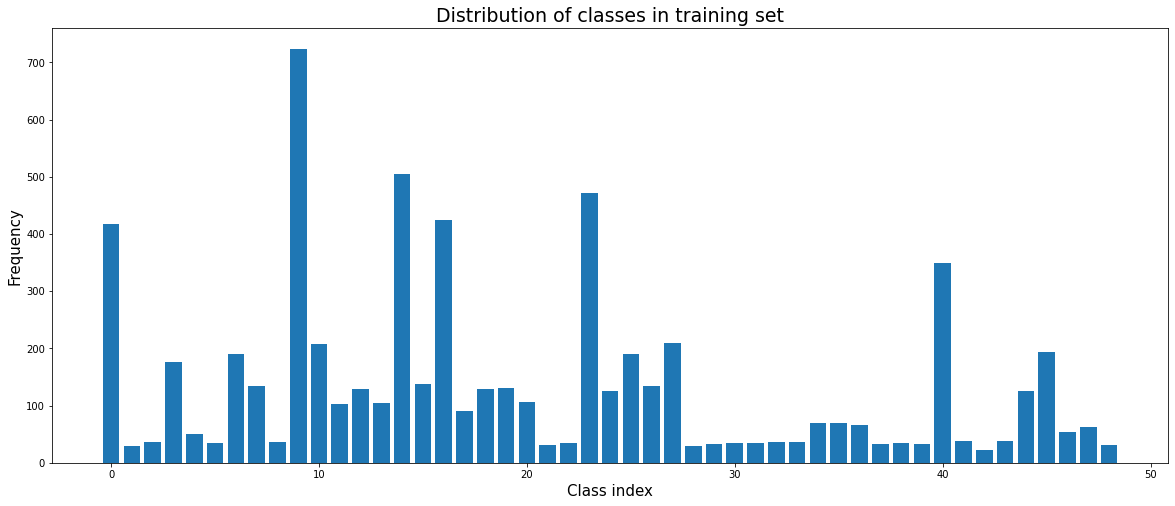

In [45]:
plt.figure(figsize=(20, 8))
count_classes_train = df_train[new_class_names].sum(axis=0).values
bins = np.arange(0, len(new_class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

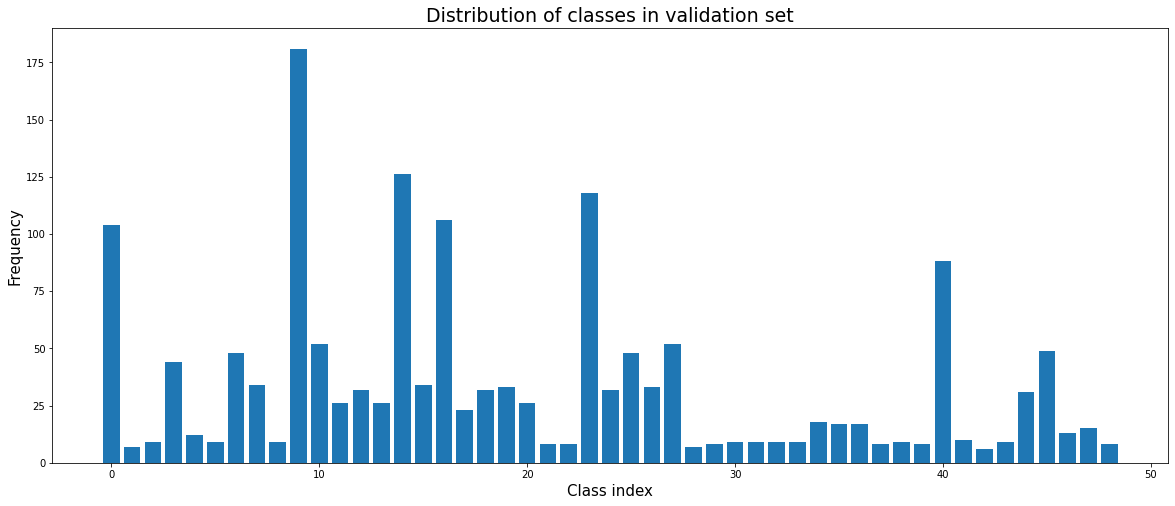

In [46]:
# check distribution of test set
plt.figure(figsize=(20, 8))
count_classes_test = df_val[new_class_names].sum(axis=0).values
bins = np.arange(0, len(new_class_names))
plt.bar(x=bins, height=count_classes_test)
plt.title("Distribution of classes in validation set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

## Create Tensorflow Input Pipeline

In [47]:
import imgaug.augmenters as iaa

def apply_augmentations(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0)
               ]
    for idx, aug in enumerate(aug_list):
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        random_nr = np.random.rand()
        input_image = np.clip(aug(images=input_image), 0., 255.) if random_nr <= 0.8 else input_image
    
    return np.squeeze(input_image, axis=0)

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentations)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [49]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data\car_ims"
batch_size = 8
shuffle = True
target_size = (128, 128)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filename", y_col=df_train.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_val, directory=path_to_images,
                                                    x_col="filename", y_col=df_val.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 6515 validated image filenames.
Found 1629 validated image filenames.


Now: Check the format in order to ensure that the images are valid when they are entered into the CNN.

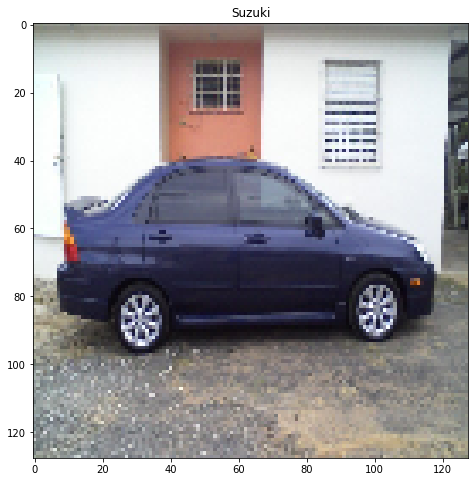

In [50]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

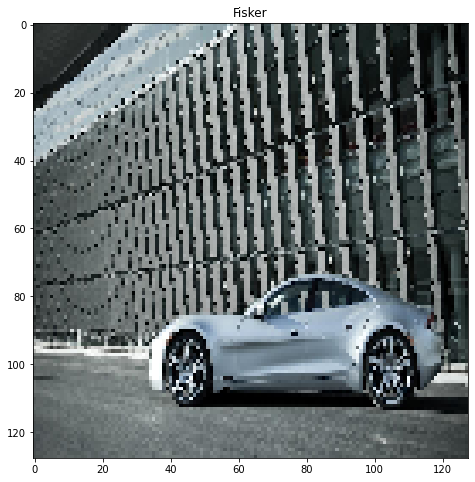

In [51]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

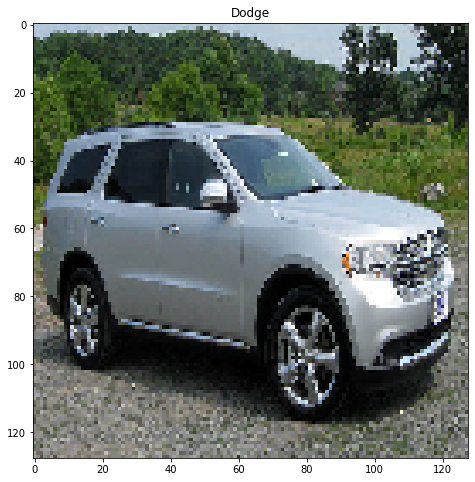

In [52]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(new_class_names[np.argmax(label)])
plt.imshow(image)

Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [53]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str) or 
           model_name not in ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]):
                raise ValueError("Input model_name is invalid! Check if it is of type string and if its in the list of models.")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.keras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [71]:
# test keras factory
factory = KerasModelFactory()

model = factory.create_and_return_keras_model("efficientnetb0", 
                                              num_classes=len(new_class_names), 
                                              input_shape=(128, 128, 3),
                                              activation_func="softmax",
                                              transfer_learning=True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 128, 128, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

Let's now train the EfficientNetB0 for a small amount of epochs in order to check whether the task is learnable or not.

In [72]:
initial_learning_rate = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(),
    keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

In [73]:
# train for 5 epochs
hist_dict = model.fit(train_generator, epochs=5, shuffle=True, verbose=1, validation_data=valid_generator)

Epoch 1/5
815/815 [==============================] - 777s 940ms/step - loss: 3.1144 - categorical_accuracy: 0.1866 - auc: 0.8194 - f1_score: 0.0588 - val_loss: 4.3555 - val_categorical_accuracy: 0.0184 - val_auc: 0.6397 - val_f1_score: 0.0000e+00
Epoch 2/5
815/815 [==============================] - 882s 1s/step - loss: 2.3302 - categorical_accuracy: 0.3523 - auc: 0.9120 - f1_score: 0.2406 - val_loss: 8.7258 - val_categorical_accuracy: 0.0055 - val_auc: 0.4874 - val_f1_score: 6.0713e-05
Epoch 3/5
815/815 [==============================] - 783s 961ms/step - loss: 1.8418 - categorical_accuracy: 0.4774 - auc: 0.9454 - f1_score: 0.4077 - val_loss: 5.8294 - val_categorical_accuracy: 0.0104 - val_auc: 0.3969 - val_f1_score: 0.0024
Epoch 4/5
312/815 [==========>...................] - ETA: 7:20 - loss: 1.4360 - categorical_accuracy: 0.5789 - auc: 0.9676 - f1_score: 0.5294

KeyboardInterrupt: 

Let's now compare different cnn encoders and choose the best one by considering the number of trainable parameters and the performance on the validation set. <br>
A cross-validation would be good for choosing the models. However, I decided to not use a cross validation in order to speed up the training process a little bit. <br> <br>
Steps for training the different encoders:
1. Train encoder for 20 epochs and store best validation f1-score of the encoder.
2. Create a plot with trainable parameters on x-axis and best score on y-axis. 
3. Use plot to decide which cnn architecture to use.

In [ ]:
encoder_list = ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
num_epochs = 20
results_dict = dict()

for encoder in encoder_list:
    model = factory.create_and_return_keras_model("efficientnetb0", 
                                              num_classes=len(new_class_names), 
                                              input_shape=(128, 128, 3),
                                              activation_func="softmax",
                                              transfer_learning=True)
    
    initial_learning_rate = 1e-3
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(new_class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    hist_dict = model.fit(train_generator, epochs=num_epochs, shuffle=True, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = [np.max(hist_dict["val_f1_score"]), np.max(hist_dict["val_categorical_accuracy"])]

In [ ]:
# Next Steps: 
# 1. Check data distribution
# 2. Create tensorflow input pipeline with normalization, conversion to grayscale
# 3. Use small images to find best suited cnn
# 4. Check different images sizes on winning cnn.
# 5. Apply data augmentation.
# 6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
# 7. Plot Class Activation Maps.